We download what we need from Dropbox: the folder with the **datasets** and the **utils** folder, finally we download the `nflows` package.

In [1]:
!mkdir utils
!mkdir data
!wget --output-document=./utils/model.py https://www.dropbox.com/scl/fi/oeg1y91gac3n6r2c6fy8a/model.py?rlkey=md6usebq5ohs719nww1nnf1l7&dl=0
!wget --output-document=./utils/our_classes.py https://www.dropbox.com/scl/fi/ie09b9yopcgo2kocw4xwg/our_classes.py?rlkey=278jhkw4zghpirwwvyregg6kw&dl=0
!wget --output-document=./data/dataset_piccolo.txt https://www.dropbox.com/scl/fi/1m1o6kdbeyd6sid8yuw8q/dataset_piccolo.txt?rlkey=hl8xvtrqj3mch3kjzjegw3wns&dl=0
!wget --output-document=./data/dataset.txt https://www.dropbox.com/scl/fi/wsw8e5uitd50tbjactzl3/dataset.txt?rlkey=arv1nh6dpwg1ipmehf5cvx9y5&dl=0
!wget --output-document=./data/test_dataset.txt https://www.dropbox.com/scl/fi/jhkucfrge74eu65bf5iqy/test_dataset.txt?rlkey=wjgg3rd72t3u47rr0ex8tbwj6&dl=0

!pip install nflows

--2024-02-13 16:43:43--  https://www.dropbox.com/scl/fi/oeg1y91gac3n6r2c6fy8a/model.py?rlkey=md6usebq5ohs719nww1nnf1l7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc888d45bda299ed4316ad8083d7.dl.dropboxusercontent.com/cd/0/inline/CNOJ3BRILP0B9mV9FmbCGn280k_k0cVQqfEEgJ2nCW4Hh1tMMvWqi9UOal88JbFHKKeBEVfHO4iC2l6mTwJ-3guqDLCysNEDO4CvHIEpiYy5sNX9Bu-uUueVlH2WrQnz2VY9FfolSSDV8yeN7oqgSaZ_/file# [following]
--2024-02-13 16:43:45--  https://uc888d45bda299ed4316ad8083d7.dl.dropboxusercontent.com/cd/0/inline/CNOJ3BRILP0B9mV9FmbCGn280k_k0cVQqfEEgJ2nCW4Hh1tMMvWqi9UOal88JbFHKKeBEVfHO4iC2l6mTwJ-3guqDLCysNEDO4CvHIEpiYy5sNX9Bu-uUueVlH2WrQnz2VY9FfolSSDV8yeN7oqgSaZ_/file
Resolving uc888d45bda299ed4316ad8083d7.dl.dropboxusercontent.com (uc888d45bda299ed4316ad8083d7.dl.dropboxusercontent.com)... 162.125.65.15, 2620:10

In [9]:
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.base import InverseTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.permutations import RandomPermutation

import torch
from torch import optim
from torchvision import models

from sklearn import preprocessing
from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor
from tqdm import tqdm

import scipy.special
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import stat
import time

The original data has 24 features, we created a dictionary to contain the names and units of measurement.

In [3]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

Import of *training*, *validation* and *test* datasets. For simplicity and to make calculations faster we have limited ourselves to the first four features. We also limited ourselves on the number of events, mainly to avoid running out of GPU memory.<br>
The number of events considered before and after the reduction is printed, together with an example event, the 100th.

In [4]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}\n'.format(L))

x = x[:int(L/1),:]
xval = xval[:200000,:]
xtest = xtest[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest = xtest[:,0:num_features]

print('Events = {}\n'.format(len(x)))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

Number of events in all the training dataset = 472827

Events = 472827

attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



Here a preprocessing procedure is applied to the input data, using the `forward` method of the `Preprocessor` class defined by us.<br>
We apply the logarithm on $p_T$ and on $mass$, after shifting the data to ensure that they were far from divergence. Then we bring all data to zero mean and unit variance with `StandardScaler`. Finally we apply the `QuantileTransformer` to bring $\eta$ and $\phi$ into a normal distribution, this last transformation is particularly suitable for training of angular distributions. The `preprocessor_settings` dictionary is created to contain this information.

We define a preprocessor for both the training and validation data, so we will do the inverse transformation by calling the `backward` method.<br>
The preprocessed data is brought to the GPU, where the flow works.

In [5]:
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([1,2]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Below we report the plot for the distributions of the original and preprocessed data.

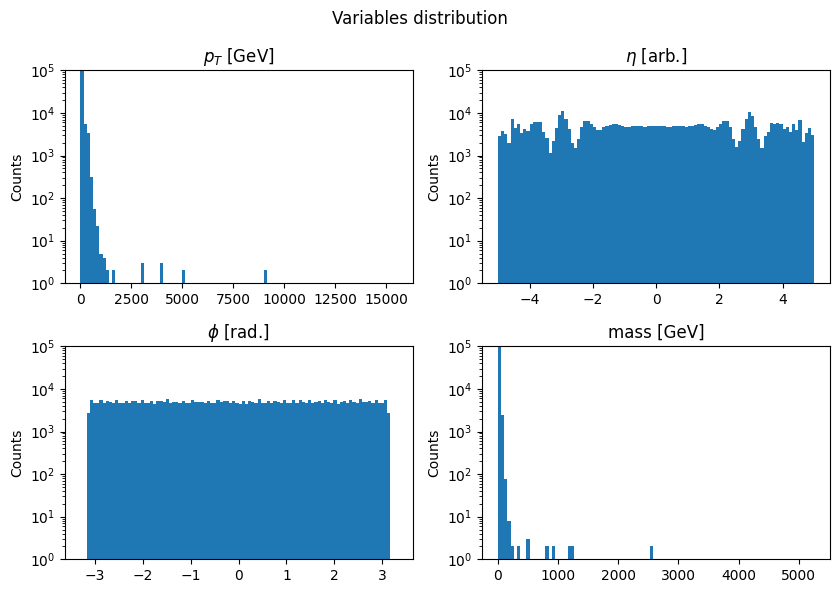

In [6]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
!mkdir figures
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

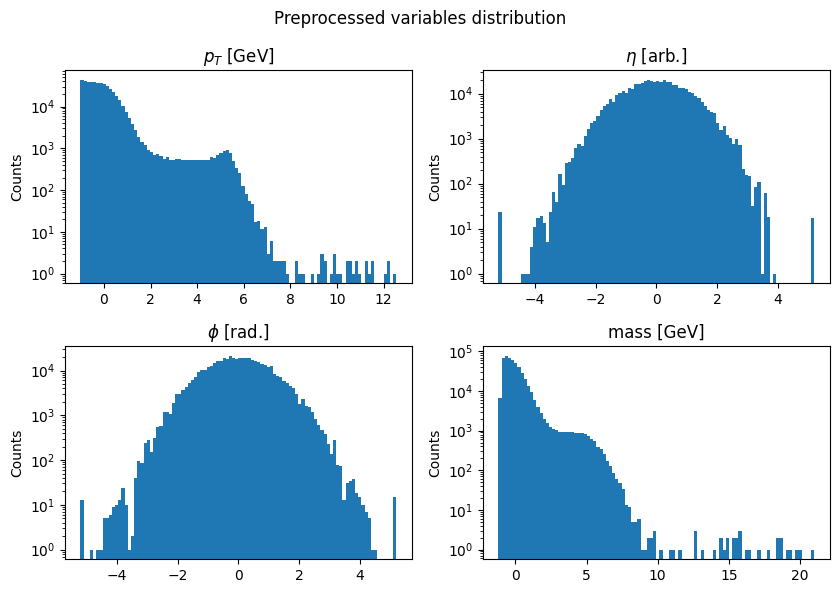

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)

Before actually training the model, we tried to understand which parameters are best. The flow is trained for a different number of transformations, giving the neural network that will be created an increasing number of hidden_features. <br>
We choose to train for 100 epochs, although they are not many they are sufficient to allow a comparison between the various models. See the plot below, where the validation loss is shown in dashed lines.


In [16]:
###Model Optimization
range_iterations = ([2, 4, 6, 8])
range_hidden_features = ([16, 32, 64, 128, 256])

epochs = 20
batch_size = 1024
val_batch_size = 10000

loss_storer = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))
loss_storer_val = np.zeros(shape=(len(range_iterations),len(range_hidden_features),epochs))

for j in range(len(range_iterations)):
  it = range_iterations[j]
  for k in range(len(range_hidden_features)):
    hf = range_hidden_features[k]
    flow_opt, optimizer_opt, scheduler_opt= model_definer(num_features=num_features, num_iterations=it, hidden_features=hf, patience = 2, factor = 0.5, min_lr = 1e-6)
    start_i = time.time()

    for i in range(epochs):
      epoch_loss = 0
      for jj in tqdm(range(0,len(xt),batch_size)):
        x_batch = xt[jj:jj+batch_size]
        optimizer_opt.zero_grad()
        loss_opt = -flow_opt.log_prob(inputs=x_batch).mean()
        loss_opt.backward()
        optimizer_opt.step()
        epoch_loss += loss_opt.cpu().detach()
      scheduler_opt.step(metrics=epoch_loss)
      epoch_loss /= (len(xt)//batch_size)
      loss_storer[j,k,i] = epoch_loss

      with torch.no_grad():
        epoch_val_loss = 0
        for kk in range(0, len(xval),val_batch_size):
          xval_batch = xval[kk:kk+val_batch_size]
          loss_opt_val = -flow_opt.log_prob(inputs=xval_batch).mean().cpu()
          epoch_val_loss += loss_opt_val
        epoch_val_loss /= (len(xval)//val_batch_size)
        loss_storer_val[j,k,i] = epoch_val_loss
    end_i = time.time()
    print('Time = {:0.05} s\n'.format(end_i-start_i))

Num. iterations = 2, Num. hidden_features = 16, Num. trainable parameters = 2608


100%|██████████| 462/462 [00:02<00:00, 202.66it/s]


Time = 51.336 s

Num. iterations = 2, Num. hidden_features = 32, Num. trainable parameters = 9296


100%|██████████| 462/462 [00:03<00:00, 140.82it/s]


Time = 50.6 s

Num. iterations = 2, Num. hidden_features = 64, Num. trainable parameters = 34960


100%|██████████| 462/462 [00:02<00:00, 210.39it/s]


Time = 49.219 s

Num. iterations = 2, Num. hidden_features = 128, Num. trainable parameters = 135440


100%|██████████| 462/462 [00:02<00:00, 197.92it/s]


Time = 51.775 s

Num. iterations = 2, Num. hidden_features = 256, Num. trainable parameters = 533008


100%|██████████| 462/462 [00:03<00:00, 144.86it/s]


Time = 53.102 s

Num. iterations = 4, Num. hidden_features = 16, Num. trainable parameters = 5216


100%|██████████| 462/462 [00:03<00:00, 116.97it/s]


Time = 88.302 s

Num. iterations = 4, Num. hidden_features = 32, Num. trainable parameters = 18592


100%|██████████| 462/462 [00:04<00:00, 112.61it/s]


Time = 88.896 s

Num. iterations = 4, Num. hidden_features = 64, Num. trainable parameters = 69920


100%|██████████| 462/462 [00:04<00:00, 94.93it/s] 


Time = 90.014 s

Num. iterations = 4, Num. hidden_features = 128, Num. trainable parameters = 270880


100%|██████████| 462/462 [00:04<00:00, 109.97it/s]


Time = 91.697 s

Num. iterations = 4, Num. hidden_features = 256, Num. trainable parameters = 1066016


100%|██████████| 462/462 [00:04<00:00, 110.58it/s]


Time = 95.515 s

Num. iterations = 6, Num. hidden_features = 16, Num. trainable parameters = 7824


100%|██████████| 462/462 [00:05<00:00, 79.64it/s]


Time = 128.24 s

Num. iterations = 6, Num. hidden_features = 32, Num. trainable parameters = 27888


100%|██████████| 462/462 [00:06<00:00, 67.82it/s]


Time = 128.76 s

Num. iterations = 6, Num. hidden_features = 64, Num. trainable parameters = 104880


100%|██████████| 462/462 [00:06<00:00, 67.19it/s]


Time = 125.95 s

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


100%|██████████| 462/462 [00:05<00:00, 78.57it/s]


Time = 132.01 s

Num. iterations = 6, Num. hidden_features = 256, Num. trainable parameters = 1599024


100%|██████████| 462/462 [00:06<00:00, 73.57it/s]


Time = 140.01 s

Num. iterations = 8, Num. hidden_features = 16, Num. trainable parameters = 10432


100%|██████████| 462/462 [00:08<00:00, 54.09it/s]


Time = 168.35 s

Num. iterations = 8, Num. hidden_features = 32, Num. trainable parameters = 37184


100%|██████████| 462/462 [00:08<00:00, 52.19it/s]


Time = 167.85 s

Num. iterations = 8, Num. hidden_features = 64, Num. trainable parameters = 139840


100%|██████████| 462/462 [00:08<00:00, 52.11it/s]


Time = 169.0 s

Num. iterations = 8, Num. hidden_features = 128, Num. trainable parameters = 541760


100%|██████████| 462/462 [00:08<00:00, 52.25it/s]


Time = 175.8 s

Num. iterations = 8, Num. hidden_features = 256, Num. trainable parameters = 2132032


100%|██████████| 462/462 [00:09<00:00, 50.36it/s]


Time = 180.72 s



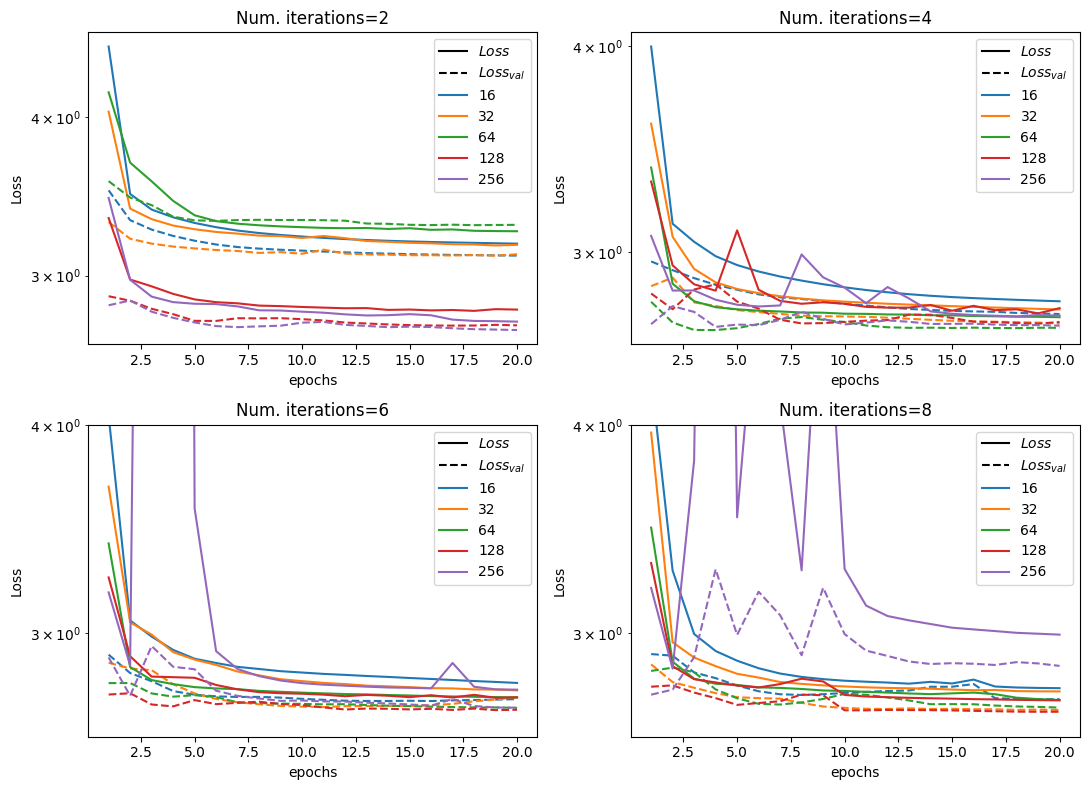

In [25]:
figlosses, axs = plt.subplots(2, 2, figsize=(11, 8))
colors = cm.tab10(np.linspace(0, 1, 10))

for j in range(len(range_iterations)):
  if j<2: axs[0][j].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[0][j].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  else: axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='-',label='$Loss$'), axs[1][j-2].plot(np.NaN, np.NaN,c='k',ls='--',label='$Loss_{val}$')
  for h in range(len(range_hidden_features)):
    if j <2:
      axs[0][j].set_title('Num. iterations={}'.format(range_iterations[j]))
      axs[0][j].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
      axs[0][j].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
      axs[0][j].set_xlabel('epochs')
      axs[0][j].set_yscale('log')
      axs[0][j].set_ylabel("Loss")
      axs[0][j].legend()
    else:
       axs[1][j-2].set_title('Num. iterations={}'.format(range_iterations[j]))
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer[j, h, :], label=range_hidden_features[h], color=colors[h])
       axs[1][j-2].plot(range(1, epochs + 1), loss_storer_val[j, h, :], ls='--', color=colors[h])
       axs[1][j-2].set_xlabel('epochs')
       axs[1][j-2].set_yscale('log')
       axs[1][j-2].set_ylabel("Loss")
       axs[1][j-2].set_ylim(bottom=2.6,top=20)
       axs[1][j-2].legend()
axs[1][0].set_ylim(top=4)
axs[1][1].set_ylim(top=4)
figlosses.tight_layout()
plt.show()
figlosses.savefig('figures/Model_optimization.pdf', dpi=190)

Now we deal with the actual training, the parameters chosen for the model are shown below. Note that although a few hundred epochs are enough for the loss to stabilize, they are not enough to allow the model to learn the extremely sharp distributions of $p_T$ and $mass$, which is why it is fixed `epochs = 2000`.





In [ ]:
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=6, hidden_features=128, patience = 5, factor = 0.5, min_lr = 1e-6)

Num. iterations = 6, Num. hidden_features = 128, Num. trainable parameters = 406320


In [ ]:
from tqdm import tqdm

100%|██████████| 462/462 [00:05<00:00, 80.33it/s]


Epoch: 0, Training loss = 24.222190856933594. Learning rate = 0.001
Validation loss = 2.8013155460357666


100%|██████████| 462/462 [00:07<00:00, 64.97it/s]


Epoch: 1, Training loss = 2.8979716300964355. Learning rate = 0.001
Validation loss = 2.7710225582122803


100%|██████████| 462/462 [00:05<00:00, 82.01it/s]


Epoch: 2, Training loss = 2.863734006881714. Learning rate = 0.001
Validation loss = 2.7533369064331055


100%|██████████| 462/462 [00:06<00:00, 67.21it/s]


Epoch: 3, Training loss = 2.824775457382202. Learning rate = 0.001
Validation loss = 2.7465436458587646


100%|██████████| 462/462 [00:06<00:00, 74.01it/s]


Epoch: 4, Training loss = 2.807901382446289. Learning rate = 0.001
Validation loss = 2.74434757232666


100%|██████████| 462/462 [00:05<00:00, 79.94it/s]


Epoch: 5, Training loss = 2.7969319820404053. Learning rate = 0.001
Validation loss = 2.7498018741607666


100%|██████████| 462/462 [00:07<00:00, 65.05it/s]


Epoch: 6, Training loss = 2.7912702560424805. Learning rate = 0.001
Validation loss = 2.7524755001068115


100%|██████████| 462/462 [00:05<00:00, 81.71it/s]


Epoch: 7, Training loss = 2.786818027496338. Learning rate = 0.001
Validation loss = 2.7553629875183105


100%|██████████| 462/462 [00:07<00:00, 65.84it/s]


Epoch: 8, Training loss = 2.785153865814209. Learning rate = 0.001
Validation loss = 2.757133722305298


100%|██████████| 462/462 [00:06<00:00, 73.99it/s]


Epoch: 9, Training loss = 2.780539035797119. Learning rate = 0.001
Validation loss = 2.7570276260375977


100%|██████████| 462/462 [00:05<00:00, 81.66it/s]


Epoch: 10, Training loss = 2.7800498008728027. Learning rate = 0.001
Validation loss = 2.7554399967193604


100%|██████████| 462/462 [00:07<00:00, 63.38it/s]


Epoch: 11, Training loss = 2.7766523361206055. Learning rate = 0.001
Validation loss = 2.75307559967041


100%|██████████| 462/462 [00:05<00:00, 78.79it/s]


Epoch: 12, Training loss = 2.7758235931396484. Learning rate = 0.001
Validation loss = 2.751629114151001


100%|██████████| 462/462 [00:06<00:00, 66.71it/s]


Epoch: 13, Training loss = 2.7727203369140625. Learning rate = 0.001
Validation loss = 2.7468836307525635


100%|██████████| 462/462 [00:06<00:00, 72.08it/s]


Epoch: 14, Training loss = 2.7737627029418945. Learning rate = 0.001
Validation loss = 2.7454419136047363


100%|██████████| 462/462 [00:05<00:00, 80.26it/s]


Epoch: 15, Training loss = 2.771354913711548. Learning rate = 0.001
Validation loss = 2.741919994354248


100%|██████████| 462/462 [00:07<00:00, 65.71it/s]


Epoch: 16, Training loss = 2.7716991901397705. Learning rate = 0.001
Validation loss = 2.7433626651763916


100%|██████████| 462/462 [00:05<00:00, 82.09it/s]


Epoch: 17, Training loss = 2.7703042030334473. Learning rate = 0.001
Validation loss = 2.743175506591797


100%|██████████| 462/462 [00:06<00:00, 67.87it/s]


Epoch: 18, Training loss = 2.7714455127716064. Learning rate = 0.001
Validation loss = 2.7454111576080322


100%|██████████| 462/462 [00:06<00:00, 70.23it/s]


Epoch: 19, Training loss = 2.7685413360595703. Learning rate = 0.001
Validation loss = 2.746959924697876


100%|██████████| 462/462 [00:05<00:00, 81.68it/s]


Epoch: 20, Training loss = 2.776785373687744. Learning rate = 0.001
Validation loss = 2.7461016178131104


100%|██████████| 462/462 [00:07<00:00, 65.07it/s]


Epoch: 21, Training loss = 2.766911745071411. Learning rate = 0.001
Validation loss = 2.7493467330932617


100%|██████████| 462/462 [00:05<00:00, 80.31it/s]


Epoch: 22, Training loss = 2.7723116874694824. Learning rate = 0.001
Validation loss = 2.790062189102173


100%|██████████| 462/462 [00:06<00:00, 68.60it/s]


Epoch: 23, Training loss = 2.7661519050598145. Learning rate = 0.001
Validation loss = 2.796309471130371


100%|██████████| 462/462 [00:06<00:00, 73.39it/s]


Epoch: 24, Training loss = 2.7706897258758545. Learning rate = 0.001
Validation loss = 2.78476619720459


100%|██████████| 462/462 [00:05<00:00, 82.30it/s]


Epoch: 25, Training loss = 2.7650933265686035. Learning rate = 0.001
Validation loss = 2.788790702819824


100%|██████████| 462/462 [00:07<00:00, 65.24it/s]


Epoch: 26, Training loss = 2.7650203704833984. Learning rate = 0.001
Validation loss = 2.778426170349121


100%|██████████| 462/462 [00:05<00:00, 81.09it/s]


Epoch: 27, Training loss = 2.763458728790283. Learning rate = 0.001
Validation loss = 2.781444787979126


100%|██████████| 462/462 [00:06<00:00, 67.50it/s]


Epoch: 28, Training loss = 2.763444185256958. Learning rate = 0.001
Validation loss = 2.7832348346710205


100%|██████████| 462/462 [00:06<00:00, 75.24it/s]


Epoch: 29, Training loss = 2.7620840072631836. Learning rate = 0.001
Validation loss = 2.773972749710083


100%|██████████| 462/462 [00:05<00:00, 80.29it/s]


Epoch: 30, Training loss = 2.763286828994751. Learning rate = 0.001
Validation loss = 2.756810188293457


100%|██████████| 462/462 [00:07<00:00, 65.96it/s]


Epoch: 31, Training loss = 2.759103298187256. Learning rate = 0.001
Validation loss = 2.7495648860931396


100%|██████████| 462/462 [00:05<00:00, 82.10it/s]


Epoch: 32, Training loss = 2.763477325439453. Learning rate = 0.001
Validation loss = 2.7391786575317383


100%|██████████| 462/462 [00:07<00:00, 65.84it/s]


Epoch: 33, Training loss = 2.7571182250976562. Learning rate = 0.001
Validation loss = 2.7341108322143555


100%|██████████| 462/462 [00:06<00:00, 75.30it/s]


Epoch: 34, Training loss = 2.758080005645752. Learning rate = 0.001
Validation loss = 2.726595878601074


100%|██████████| 462/462 [00:05<00:00, 80.86it/s]


Epoch: 35, Training loss = 2.7557435035705566. Learning rate = 0.001
Validation loss = 2.72410249710083


100%|██████████| 462/462 [00:07<00:00, 62.99it/s]


Epoch: 36, Training loss = 2.7558329105377197. Learning rate = 0.001
Validation loss = 2.7143442630767822


100%|██████████| 462/462 [00:05<00:00, 81.24it/s]


Epoch: 37, Training loss = 2.752314805984497. Learning rate = 0.001
Validation loss = 2.714550495147705


100%|██████████| 462/462 [00:06<00:00, 66.64it/s]


Epoch: 38, Training loss = 2.7535347938537598. Learning rate = 0.001
Validation loss = 2.7121362686157227


100%|██████████| 462/462 [00:06<00:00, 75.28it/s]


Epoch: 39, Training loss = 2.7500200271606445. Learning rate = 0.001
Validation loss = 2.7052993774414062


100%|██████████| 462/462 [00:05<00:00, 79.60it/s]


Epoch: 40, Training loss = 2.7492313385009766. Learning rate = 0.001
Validation loss = 2.705552101135254


100%|██████████| 462/462 [00:07<00:00, 64.53it/s]


Epoch: 41, Training loss = 2.748401403427124. Learning rate = 0.001
Validation loss = 2.7051732540130615


100%|██████████| 462/462 [00:05<00:00, 77.93it/s]


Epoch: 42, Training loss = 2.746945381164551. Learning rate = 0.001
Validation loss = 2.7070116996765137


100%|██████████| 462/462 [00:07<00:00, 65.73it/s]


Epoch: 43, Training loss = 2.7474958896636963. Learning rate = 0.001
Validation loss = 2.7093112468719482


100%|██████████| 462/462 [00:06<00:00, 71.16it/s]


Epoch: 44, Training loss = 2.7453677654266357. Learning rate = 0.001
Validation loss = 2.7163891792297363


100%|██████████| 462/462 [00:05<00:00, 81.86it/s]


Epoch: 45, Training loss = 2.755469799041748. Learning rate = 0.001
Validation loss = 2.725649833679199


100%|██████████| 462/462 [00:06<00:00, 66.13it/s]


Epoch: 46, Training loss = 2.7473044395446777. Learning rate = 0.001
Validation loss = 2.729820728302002


100%|██████████| 462/462 [00:05<00:00, 81.91it/s]


Epoch: 47, Training loss = 2.7583866119384766. Learning rate = 0.001
Validation loss = 2.732539176940918


100%|██████████| 462/462 [00:07<00:00, 65.95it/s]


Epoch: 48, Training loss = 2.888148546218872. Learning rate = 0.001
Validation loss = 2.798663854598999


100%|██████████| 462/462 [00:06<00:00, 73.44it/s]


Epoch: 49, Training loss = 4.230177402496338. Learning rate = 0.001
Validation loss = 2.7699174880981445


100%|██████████| 462/462 [00:05<00:00, 81.93it/s]


Epoch: 50, Training loss = 2.767752170562744. Learning rate = 0.0005
Validation loss = 2.738490104675293


100%|██████████| 462/462 [00:07<00:00, 65.38it/s]


Epoch: 51, Training loss = 2.7477633953094482. Learning rate = 0.0005
Validation loss = 2.7337329387664795


100%|██████████| 462/462 [00:05<00:00, 82.11it/s]


Epoch: 52, Training loss = 2.7410383224487305. Learning rate = 0.0005
Validation loss = 2.730476140975952


100%|██████████| 462/462 [00:06<00:00, 66.16it/s]


Epoch: 53, Training loss = 2.7376480102539062. Learning rate = 0.0005
Validation loss = 2.729893207550049


100%|██████████| 462/462 [00:06<00:00, 76.86it/s]


Epoch: 54, Training loss = 2.735421657562256. Learning rate = 0.0005
Validation loss = 2.727269172668457


100%|██████████| 462/462 [00:05<00:00, 77.70it/s]


Epoch: 55, Training loss = 2.7336184978485107. Learning rate = 0.0005
Validation loss = 2.727611541748047


100%|██████████| 462/462 [00:07<00:00, 65.70it/s]


Epoch: 56, Training loss = 2.732574701309204. Learning rate = 0.0005
Validation loss = 2.7278482913970947


100%|██████████| 462/462 [00:05<00:00, 83.04it/s]


Epoch: 57, Training loss = 2.7313661575317383. Learning rate = 0.0005
Validation loss = 2.727288246154785


100%|██████████| 462/462 [00:07<00:00, 65.84it/s]


Epoch: 58, Training loss = 2.7313313484191895. Learning rate = 0.0005
Validation loss = 2.724407196044922


100%|██████████| 462/462 [00:05<00:00, 77.67it/s]


Epoch: 59, Training loss = 2.729401111602783. Learning rate = 0.0005
Validation loss = 2.7258753776550293


100%|██████████| 462/462 [00:05<00:00, 78.18it/s]


Epoch: 60, Training loss = 2.7293407917022705. Learning rate = 0.0005
Validation loss = 2.721855640411377


100%|██████████| 462/462 [00:07<00:00, 65.58it/s]


Epoch: 61, Training loss = 2.728681802749634. Learning rate = 0.0005
Validation loss = 2.724856376647949


100%|██████████| 462/462 [00:05<00:00, 81.25it/s]


Epoch: 62, Training loss = 2.7290782928466797. Learning rate = 0.0005
Validation loss = 2.7231035232543945


100%|██████████| 462/462 [00:07<00:00, 65.21it/s]


Epoch: 63, Training loss = 2.731008768081665. Learning rate = 0.0005
Validation loss = 2.7233235836029053


100%|██████████| 462/462 [00:05<00:00, 78.28it/s]


Epoch: 64, Training loss = 2.7352688312530518. Learning rate = 0.0005
Validation loss = 2.726707696914673


100%|██████████| 462/462 [00:05<00:00, 77.28it/s]


Epoch: 65, Training loss = 2.7306931018829346. Learning rate = 0.0005
Validation loss = 2.7230000495910645


100%|██████████| 462/462 [00:07<00:00, 65.44it/s]


Epoch: 66, Training loss = 2.7275359630584717. Learning rate = 0.0005
Validation loss = 2.722153902053833


100%|██████████| 462/462 [00:05<00:00, 80.74it/s]


Epoch: 67, Training loss = 2.726905584335327. Learning rate = 0.0005
Validation loss = 2.7221269607543945


100%|██████████| 462/462 [00:07<00:00, 65.92it/s]


Epoch: 68, Training loss = 2.7262561321258545. Learning rate = 0.0005
Validation loss = 2.7232203483581543


100%|██████████| 462/462 [00:05<00:00, 78.77it/s]


Epoch: 69, Training loss = 2.7267513275146484. Learning rate = 0.0005
Validation loss = 2.7227365970611572


100%|██████████| 462/462 [00:06<00:00, 75.15it/s]


Epoch: 70, Training loss = 2.726552724838257. Learning rate = 0.0005
Validation loss = 2.7221057415008545


100%|██████████| 462/462 [00:07<00:00, 65.71it/s]


Epoch: 71, Training loss = 2.7317707538604736. Learning rate = 0.0005
Validation loss = 2.7223317623138428


100%|██████████| 462/462 [00:05<00:00, 81.34it/s]


Epoch: 72, Training loss = 2.7304751873016357. Learning rate = 0.0005
Validation loss = 2.7229604721069336


100%|██████████| 462/462 [00:07<00:00, 65.98it/s]


Epoch: 73, Training loss = 2.7277064323425293. Learning rate = 0.0005
Validation loss = 2.7231569290161133


100%|██████████| 462/462 [00:05<00:00, 80.75it/s]


Epoch: 74, Training loss = 2.7272040843963623. Learning rate = 0.00025
Validation loss = 2.725996971130371


100%|██████████| 462/462 [00:06<00:00, 74.29it/s]


Epoch: 75, Training loss = 2.719843626022339. Learning rate = 0.00025
Validation loss = 2.7207021713256836


100%|██████████| 462/462 [00:06<00:00, 67.10it/s]


Epoch: 76, Training loss = 2.718456983566284. Learning rate = 0.00025
Validation loss = 2.7207934856414795


100%|██████████| 462/462 [00:05<00:00, 81.41it/s]


Epoch: 77, Training loss = 2.7190873622894287. Learning rate = 0.00025
Validation loss = 2.720050573348999


100%|██████████| 462/462 [00:06<00:00, 66.16it/s]


Epoch: 78, Training loss = 2.7185733318328857. Learning rate = 0.00025
Validation loss = 2.7211713790893555


100%|██████████| 462/462 [00:05<00:00, 82.17it/s]


Epoch: 79, Training loss = 2.7188918590545654. Learning rate = 0.00025
Validation loss = 2.721074104309082


100%|██████████| 462/462 [00:06<00:00, 71.36it/s]


Epoch: 80, Training loss = 2.718528985977173. Learning rate = 0.00025
Validation loss = 2.723174810409546


100%|██████████| 462/462 [00:06<00:00, 67.59it/s]


Epoch: 81, Training loss = 2.7186107635498047. Learning rate = 0.00025
Validation loss = 2.7235987186431885


100%|██████████| 462/462 [00:05<00:00, 81.35it/s]


Epoch: 82, Training loss = 2.7183516025543213. Learning rate = 0.000125
Validation loss = 2.7245187759399414


100%|██████████| 462/462 [00:07<00:00, 66.00it/s]


Epoch: 83, Training loss = 2.7129976749420166. Learning rate = 0.000125
Validation loss = 2.72487735748291


100%|██████████| 462/462 [00:05<00:00, 81.92it/s]


Epoch: 84, Training loss = 2.7128756046295166. Learning rate = 0.000125
Validation loss = 2.724595069885254


100%|██████████| 462/462 [00:06<00:00, 70.49it/s]


Epoch: 85, Training loss = 2.7128617763519287. Learning rate = 0.000125
Validation loss = 2.72445011138916


100%|██████████| 462/462 [00:06<00:00, 69.55it/s]


Epoch: 86, Training loss = 2.712864875793457. Learning rate = 0.000125
Validation loss = 2.723536491394043


100%|██████████| 462/462 [00:05<00:00, 81.56it/s]


Epoch: 87, Training loss = 2.7127866744995117. Learning rate = 0.000125
Validation loss = 2.7238309383392334


100%|██████████| 462/462 [00:07<00:00, 65.22it/s]


Epoch: 88, Training loss = 2.7127158641815186. Learning rate = 0.000125
Validation loss = 2.723376989364624


100%|██████████| 462/462 [00:05<00:00, 82.35it/s]


Epoch: 89, Training loss = 2.712601900100708. Learning rate = 0.000125
Validation loss = 2.723430633544922


100%|██████████| 462/462 [00:06<00:00, 68.73it/s]


Epoch: 90, Training loss = 2.7125537395477295. Learning rate = 0.000125
Validation loss = 2.723557710647583


100%|██████████| 462/462 [00:06<00:00, 72.29it/s]


Epoch: 91, Training loss = 2.712459087371826. Learning rate = 0.000125
Validation loss = 2.7234232425689697


100%|██████████| 462/462 [00:05<00:00, 81.61it/s]


Epoch: 92, Training loss = 2.7123684883117676. Learning rate = 0.000125
Validation loss = 2.723247766494751


100%|██████████| 462/462 [00:07<00:00, 65.97it/s]


Epoch: 93, Training loss = 2.7122678756713867. Learning rate = 0.000125
Validation loss = 2.723518133163452


100%|██████████| 462/462 [00:05<00:00, 81.76it/s]


Epoch: 94, Training loss = 2.712146043777466. Learning rate = 0.000125
Validation loss = 2.723202705383301


100%|██████████| 462/462 [00:06<00:00, 67.53it/s]


Epoch: 95, Training loss = 2.7120628356933594. Learning rate = 0.000125
Validation loss = 2.7235631942749023


100%|██████████| 462/462 [00:06<00:00, 75.26it/s]


Epoch: 96, Training loss = 2.711949586868286. Learning rate = 0.000125
Validation loss = 2.7238125801086426


100%|██████████| 462/462 [00:05<00:00, 80.54it/s]


Epoch: 97, Training loss = 2.711904525756836. Learning rate = 0.000125
Validation loss = 2.723811149597168


100%|██████████| 462/462 [00:07<00:00, 65.79it/s]


Epoch: 98, Training loss = 2.7118918895721436. Learning rate = 0.000125
Validation loss = 2.724090337753296


100%|██████████| 462/462 [00:05<00:00, 81.05it/s]


Epoch: 99, Training loss = 2.7116777896881104. Learning rate = 0.000125
Validation loss = 2.7240400314331055
Time = 834.47 s


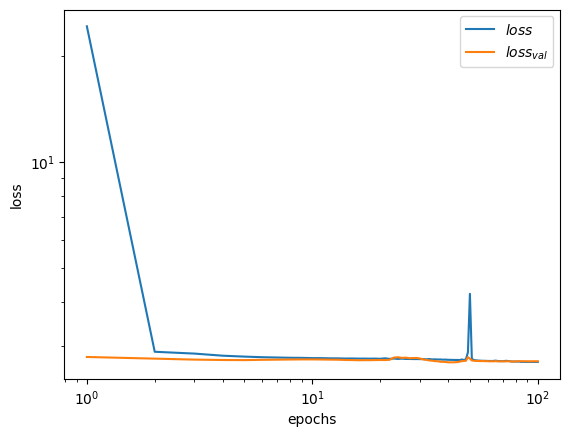

FileNotFoundError: [Errno 2] No such file or directory: 'figures/Loss_comparison.pdf'

In [ ]:
epochs = 100
batch_size = 1024
val_batch_size = 10000

figloss=plt.figure()
loss_values = []
loss_validation = []
start = time.time()
for i in range(epochs):
  epoch_loss = 0
  for j in tqdm(range(0,len(xt),batch_size)):
    x_batch = xt[j:j+batch_size]
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_batch).mean()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().detach()
  scheduler.step(metrics=epoch_loss)
  for param_group in optimizer.param_groups:
    lr = param_group['lr']
  epoch_loss /= (len(xt)//batch_size)
  loss_values.append(epoch_loss)
  print('Epoch: {}, Training loss = {}. Learning rate = {}'.format(i,epoch_loss,lr))

  with torch.no_grad():
    val_loss = 0
    for k in range(0, len(xval),val_batch_size):
      x_batch = xval[j:j+val_batch_size]
      loss_val = -flow.log_prob(inputs=xval).mean().cpu()
      val_loss += loss_val
    val_loss /= (len(xval)//val_batch_size)
    loss_validation.append(val_loss)
    print('Validation loss = {}'.format(val_loss))

end = time.time()
print('Time = {:0.05} s'.format(end-start))
plt.plot(range(1, epochs+1), loss_values, label='$loss$')
plt.plot(range(1, epochs+1), loss_validation, label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

We now report an example of application of the flow: after sending our data into a normal distribution we can use the flow to generate new data, which will have the same distribution of the original data. This is the sampling procedure. The comparison between the original data and the generated data are an indication of how much the model was able to learn in the training. <br>
Therefore, in the `quantile_variation.ipynb` file we will focus on the sampled data after applying two different preprocessing transformations. <br><br>
In order to compare the new data with the original ones we must apply the preprocessing transformation in reverse, so we use the `backward` method. The figure below shows the two distributions compared.




In [ ]:
sample_batch_size = 100000

sample = np.zeros(x.shape)
print(sample.shape)
for t in range(0,len(x), sample_batch_size):
  print(len(sample[t:t+sample_batch_size]))
  sample[t:t+sample_batch_size] = flow.sample(len(sample[t:t+sample_batch_size])).cpu().detach().numpy()

sample = x_preprocessor.backward(sample)

(472827, 4)
100000
100000
100000
100000
72827


/content/utils/our_classes.py:42: RuntimeWarning: overflow encountered in exp
  data_reconstructed[:,i] = np.exp(data_reconstructed[:,i]) - 10


ValueError: supplied range of [-10.0, inf] is not finite

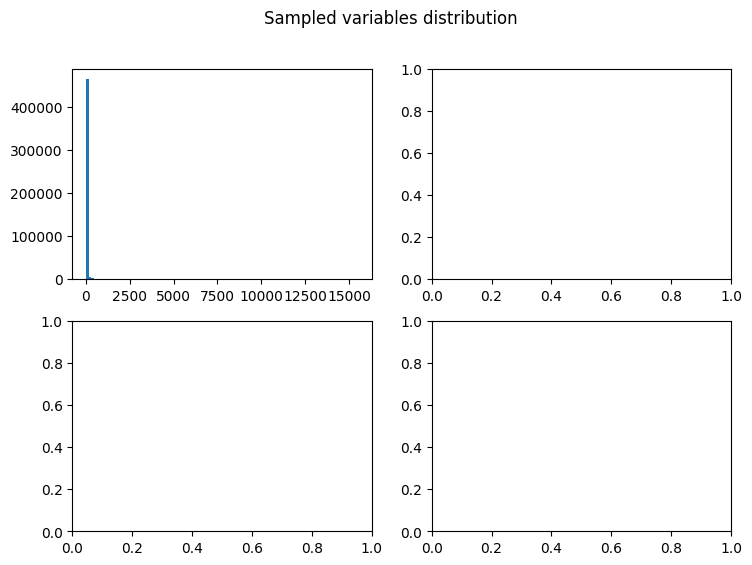

In [ ]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample.pdf',dpi=190)

To achieve lossy compression we created the `Compressor` class, it has two methods: one for compression and one for decompression. <br>The idea we want to implement is described by the following lines:
```
training
gaus = flow(data)
unif = erf(gaus)
unif' = unif * 2**N
unif'' = int(unif')
comp = unif''/2**N
gaus' = erfinv(comp)
data' = flow^-1(gaus') ==? data
```
Through the flow that we have learned we bring the original data into gaussian distributions, subsequently we can obtain uniform distributions using the `erf` function. Compression consists of casting as integer after rescaling the unit interval of the uniform distribution by a factor of `2**N`, where `N` is the number of compression bits used. We can now get the decompressed data using the `decompress` method.<br>
To make sure that the `erfinv` function does not return infinite numbers we use Scikit-learn's `MaxAbsScaler` in the `compress` method, rescaling everything to $3\sigma$. In the `decompress` method we apply the inverse transformation.





In [ ]:
###Compression###
x_compressor = Compressor(flow=flow, N=11, limit=3)
x_compressed, gaus, unif = x_compressor.compress(xt)
x_decompressed, gaus_post = x_compressor.decompress(x_compressed)
x_decompressed = x_preprocessor.backward(x_decompressed)

We now present the plots of the Gaussian distributions returned by the flow,when it acts on the data. In the off-diagonal elements, the distributions are reported as a function of the others, via `scatter plot`.<br>
In addition, tests on the normality of the Gaussians are also performed, using [`scipy.stats.normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html).

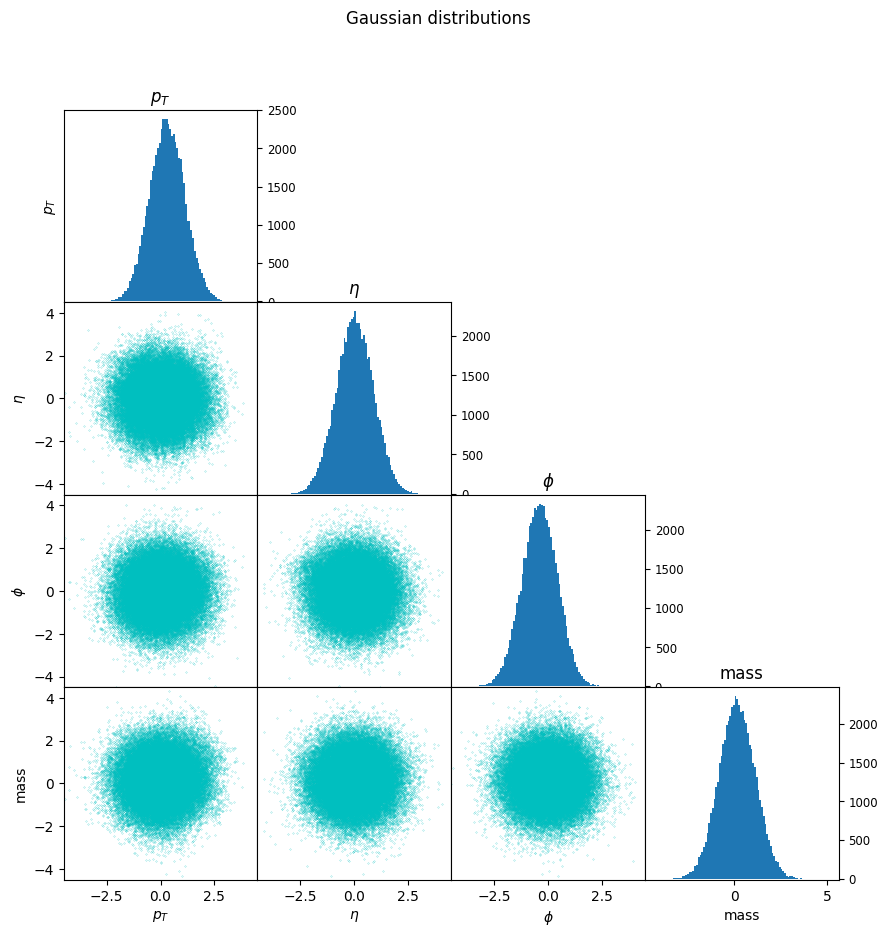

In [ ]:
figgaus, axs = plt.subplots(4,4,figsize=(10,10))
figgaus.suptitle('Gaussian distributions')
figgaus.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus[:,f], bins=n_bins)
        axs[f,f].yaxis.tick_right()
        #axs[f,f].tick_params(labelrotation=45)
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus[:,f],gaus[:,h],s=0.025,c='c')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus.savefig('figures/Gaussian_plot.pdf',dpi=190)

As we can read from the scipy documentation: $statistic = s^2+k^2$, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest. As reported [here](https://www.sciencedirect.com/topics/neuroscience/kurtosis), measures of kurtosis and skew are used to determine if indicators met normality assumptions. Both skew and kurtosis can be analyzed through descriptive statistics. Acceptable values of skewness fall between $\pm$ 3, and kurtosis is appropriate from a range of $\pm$ 10. All our results comply with the test.<br> <br>
The `pvalue` gives us information about the null hypothesis test, i.e. that our data is distributed as a $\mathcal{N}(0,1)$. The null hypothesis $H_0$ is rejected if the p-value is less than or equal to a predefined threshold value $α$, the significance level, which, in our case, is set at $\alpha = 0.05$. Looking at results obtained, we can state that $\eta$ is not distributed as a normal, while, for the other distributions, the test does not reject the null hypothesis.

### Ricorda di controllare il valore del pvalue

In [ ]:
statistic, pvalue = stats.normaltest(gaus, axis=0)
print('Statistic = {}, pvalue = {}'.format(statistic,pvalue))

Statistic = [ 0.23220454  4.7467923  19.225851    3.4236073 ], pvalue = [8.90384158e-01 9.31637894e-02 6.68589401e-05 1.80539864e-01]


As done for the gaussian distributions, the uniform distributions obtained from the `erf` function are now also shown.


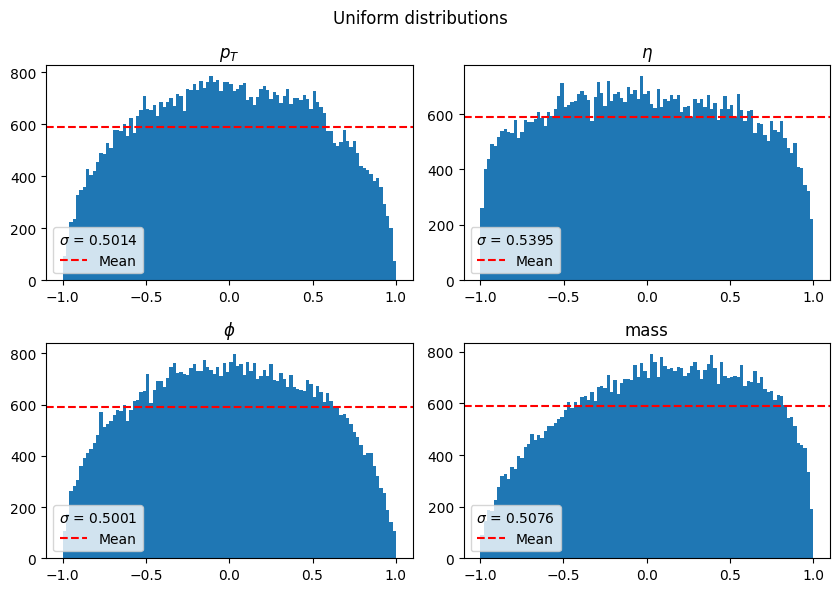

In [ ]:
figunif,axs = plt.subplots(2, 2,figsize=(8.5,6))
figunif.suptitle('Uniform distributions')
n_bins = 100
mean=len(x)/n_bins

axs[0, 0].hist(unif[:,0],bins=n_bins)
axs[0, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{}'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,0])),loc='lower left')

axs[0, 1].hist(unif[:,1],bins=n_bins)
axs[0, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 1].set_title('{}'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,1])),loc='lower left')

axs[1, 0].hist(unif[:,2],bins=n_bins)
axs[1, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 0].set_title('{}'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,2])),loc='lower left')

axs[1, 1].hist(unif[:,3],bins=n_bins)
axs[1, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 1].set_title('{}'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,3])),loc='lower left')

figunif.tight_layout()
plt.show()
figunif.savefig('figures/Uniform_plot.pdf',dpi=190)

As done for the gaussian distributions obtained from the flow, the same `normaltest` was now repeated also for the gaussian distributions obtained from `erfinv`, those after compression.



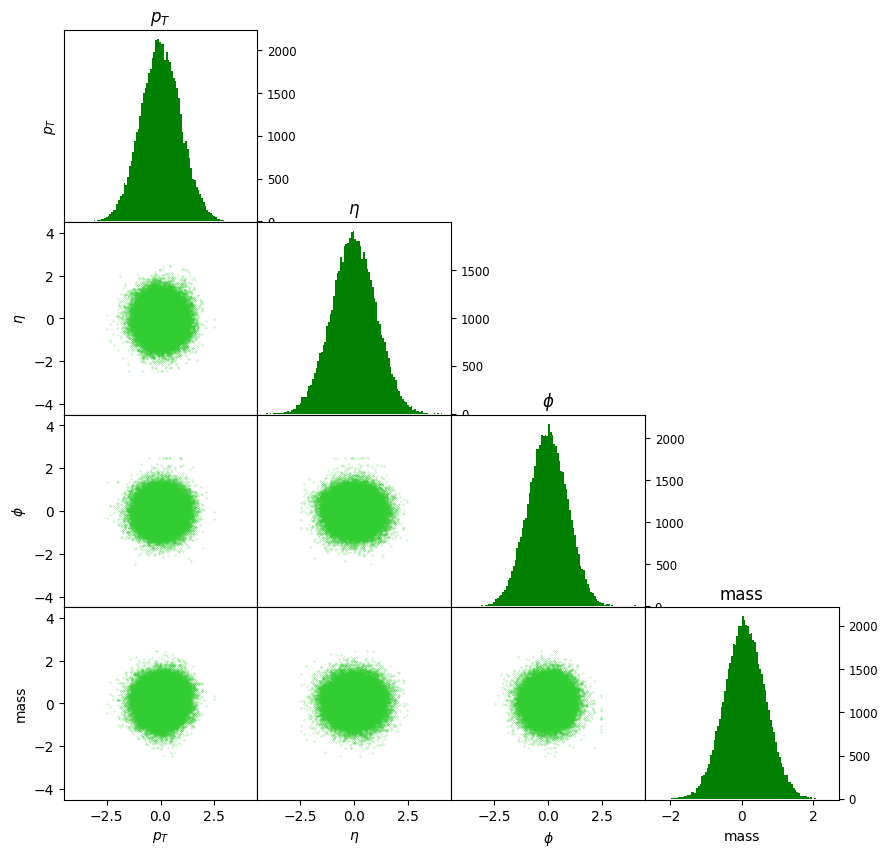

In [ ]:
figgaus_post, axs = plt.subplots(4,4,figsize=(10,10))
figgaus.suptitle('Gaussian distributions after compression')
figgaus_post.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus_post.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus_post[:,f], bins=n_bins, facecolor='g')
        axs[f,f].yaxis.tick_right()
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus_post[:,f],gaus_post[:,h],s=0.025,c='limegreen')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus_post.savefig('figures/Gaussian_post_plot.pdf',dpi=190)

In [ ]:
statistic_post, pvalue_post = stats.normaltest(gaus_post, axis=0)
print('Statistic post = {}, pvalue post = {}'.format(statistic_post,pvalue_post))

Statistic post = [1.34550956 6.64815515 5.65029662 1.31960814], pvalue post = [0.51030087 0.03600572 0.05929986 0.51695261]


We now represent the original and decompressed data, in particular by plotting the ratio and distribution of the difference.

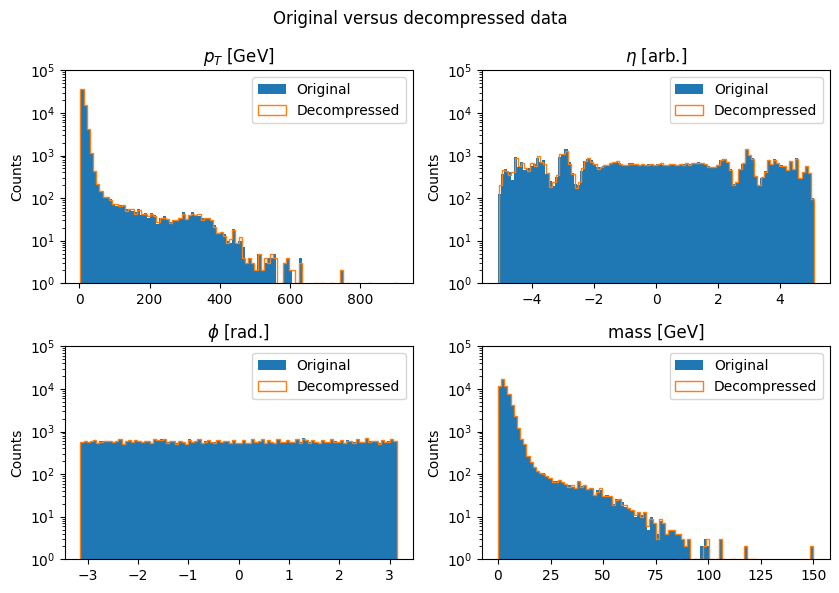

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Original versus decompressed data")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(x_decompressed[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")
axs[0, 0].set_ylim(1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(x_decompressed[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")
axs[0, 1].set_ylim(1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(x_decompressed[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(x_decompressed[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)


<ipython-input-22-fb8c1134576d>:22: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-22-fb8c1134576d>:22: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


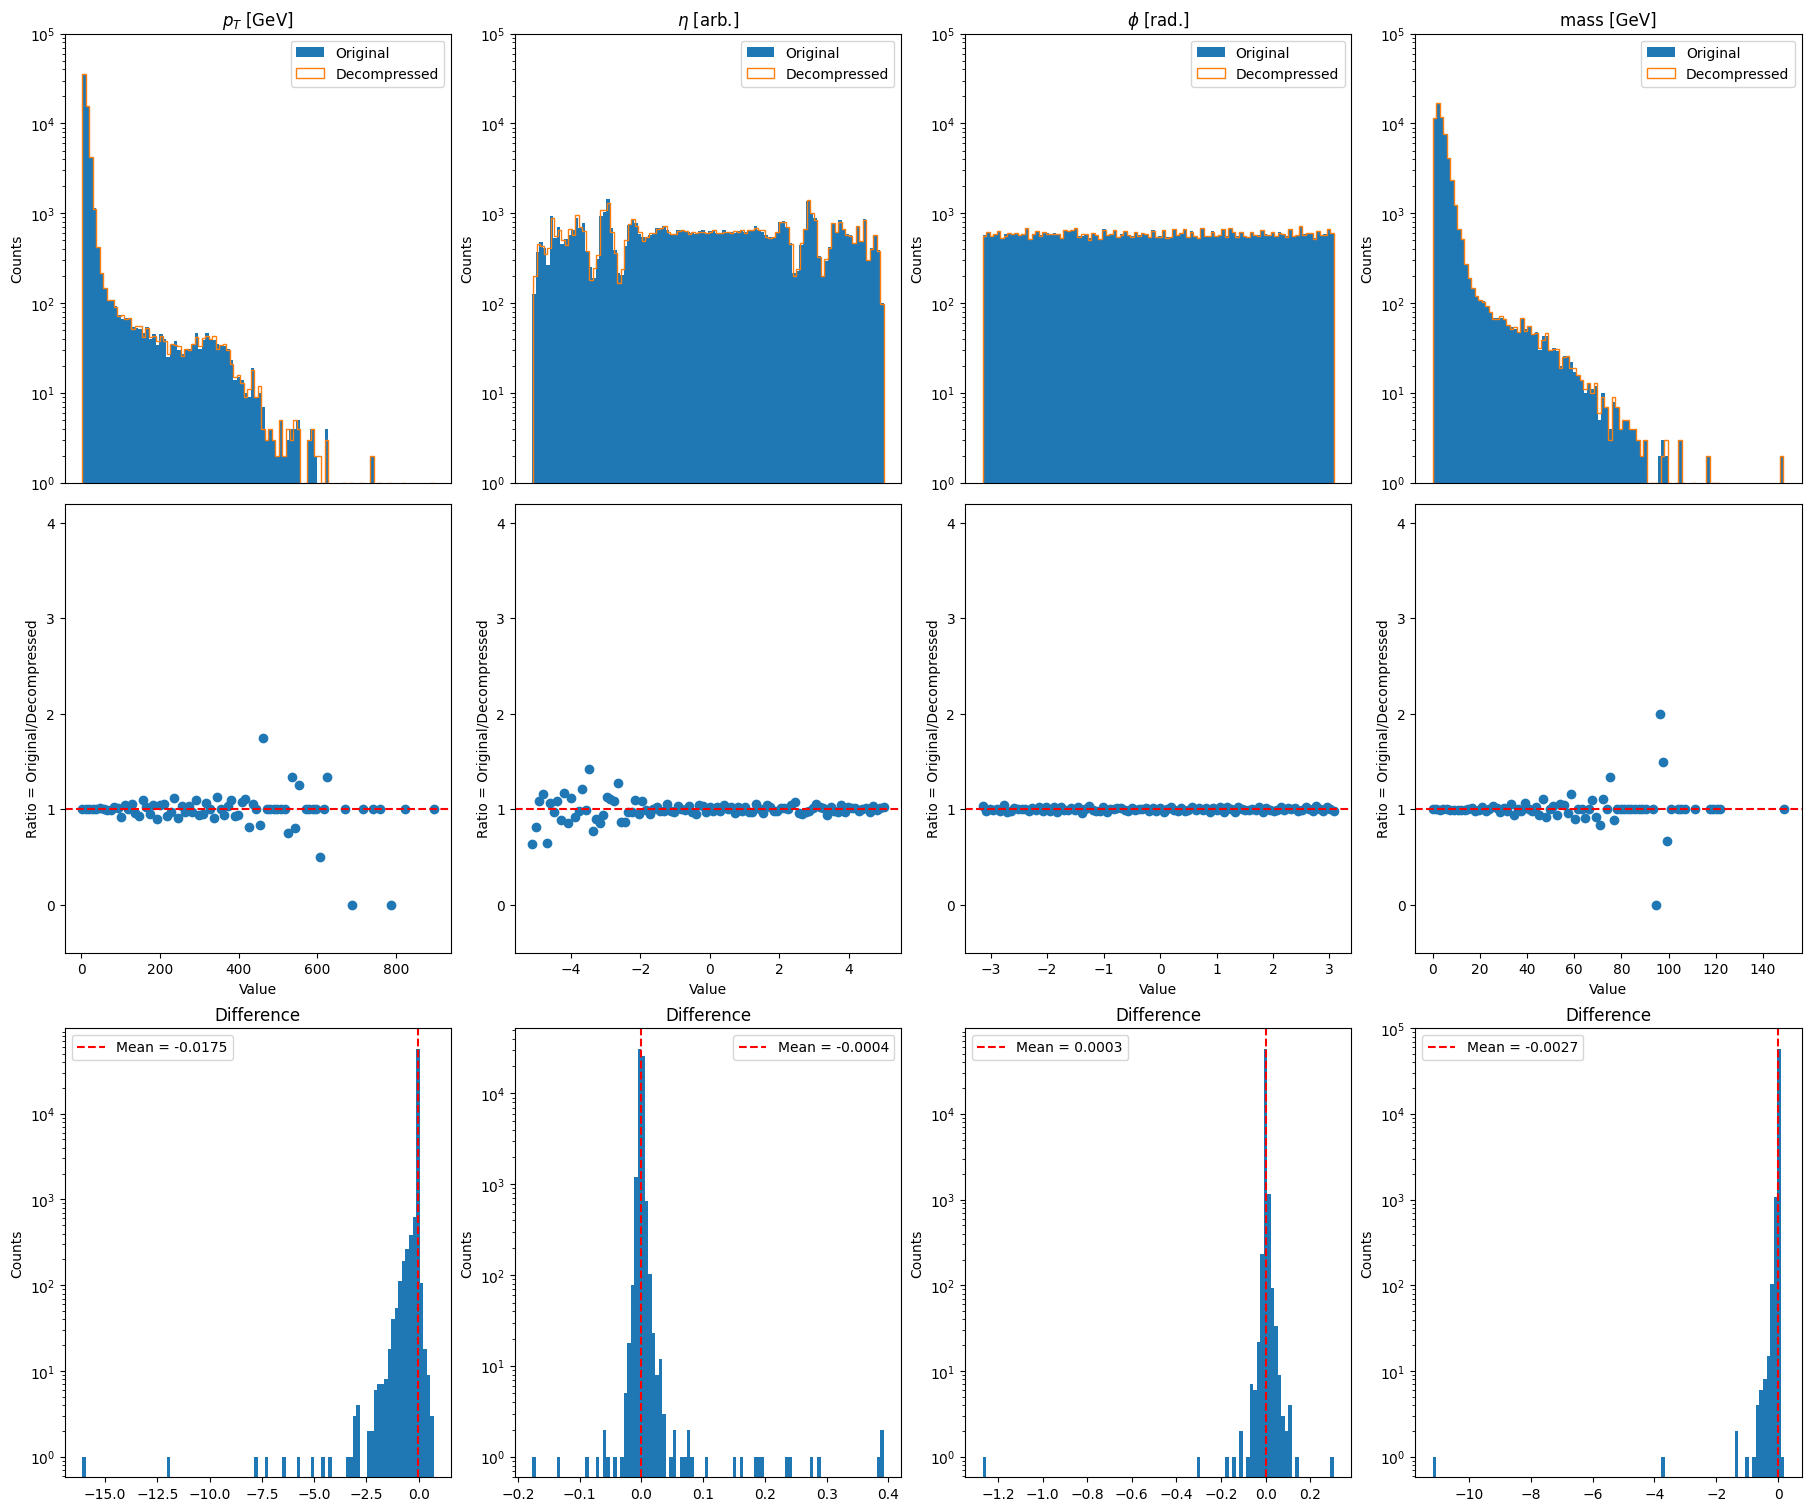

In [ ]:
difference = x_decompressed-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots")

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(x_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio = Original/Decompressed")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference.pdf', dpi=190)

To get the compression ratio, defined as:
$R = \frac{size(input~file)}{size(compressed~file)}$
, we create two new files with the used training data and the compressed one. In addition we also create a file for the decompressed data.<br>
The compression ratio is shown below.


In [ ]:
with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")


In [ ]:
size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio =',size_input/size_compressed)

Size of input file = 3.2242536544799805 MB
Size of output file = 2.27105712890625 MB
Size of compressed file = 1.0925941467285156 MB
Compression ratio = 2.9510076217542953


We now study the compression ratio, the sum of the module of the residuals and the relative error as a function of `N`.


The definition of R is given above, instead for the other two we have:
$$
Residual = original - decompressed
$$
and
$$
Relative~error =\overline{\sqrt{\overline{\Big(\frac{original-decompressed}{std(original)}\Big)^2}}}
$$
where $std(x) = \sqrt{\frac{1}{N}\sum^{N}_{i=1}(x_i-\mu)^2}$ is the standard deviation of $x$ and $\mu$ is its mean.
Furthermore, the average under the square root is done column by column using `axis=0`.<br>
As expected, a decreasing behaviour is obtained for both functions.<br>
For the compression done before and for the one we will do now on the test data we have chosen to set `N=11`, with a compression ratio of approximately 3.


In [ ]:
RR = []
residui = []
relative_error = []

for k in range(1,32):
    x_compressor_k = Compressor(flow=flow, N=k, limit=3)
    x_compressed_k, gaus_k, unif_ = x_compressor_k.compress(xt)
    x_decompressed_k, gaus_post_k = x_compressor_k.decompress(x_compressed_k)
    x_decompressed_k = x_preprocessor.backward(x_decompressed_k)

    with open('output_k.txt', 'w') as output:
        for i in range(len(x)):
            output.write(' '.join(str(x_decompressed_k[i, j]) for j in range(x_decompressed_k.shape[1])) + "\n")

    with open('compressed_k.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(x_compressed_k[i, j]) for j in range(x_compressed_k.shape[1])) + "\n")

    size_output_k = stat('output_k.txt').st_size
    size_compressed_k = stat('compressed_k.txt').st_size

    r_k = size_input/size_compressed_k
    RR.append(r_k)

    residui_k = np.sum(np.abs(x-x_decompressed_k))
    residui.append(residui_k)

    err_k =np.mean(np.sqrt(np.mean(((x - x_decompressed_k)/(x.std()))**2, axis=0)))
    relative_error.append(err_k)

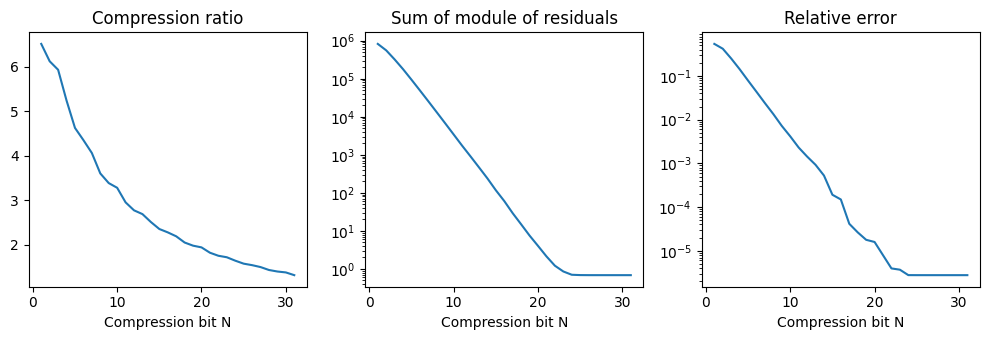

In [ ]:
fig, ax1 = plt.subplots(1,3,figsize=(10,3.5))

ax1[0].plot(range(1,k+1),RR,label='Compression ratio')
ax1[0].set_xlabel('Compression bit N')
ax1[0].set_title('Compression ratio')
ax1[0].tick_params(axis='y', which='minor', bottom=False)

ax1[1].plot(range(1,k+1),residui,label='Sum of module of residuals')
ax1[1].set_xlabel('Compression bit N')
ax1[1].set_title('Sum of module of residuals')
ax1[1].set_yscale('log')
ax1[1].tick_params(axis='y', which='minor', bottom=False)

ax1[2].plot(range(1,k+1),relative_error,label='Relative error')
ax1[2].set_xlabel('Compression bit N')
ax1[2].set_title('Relative error')
ax1[2].set_yscale('log')
ax1[2].tick_params(axis='y', which='minor', bottom=False)

fig.tight_layout()
plt.show()
fig.savefig('figures/Compression_ratio.pdf',dpi=190)

We now perform compression on the test data, which is different from both the training and validation data. The procedure is similar to the one carried out previously: the data is preprocessed,the flow is used to compress this data and then it goes back, using `decompress` and `backward`. <br>
We always set `N=11` and the result is still approximately 3.

In [ ]:
###TESTING
xtest_preprocessor = Preprocessor(preprocessor_settings)
xtest_preprocessed = xtest_preprocessor.forward(xtest)
xtest_compressed, gaus_test, unif_test = x_compressor.compress(xtest_preprocessed)
xtest_decompressed, gaus_test_post = x_compressor.decompress(xtest_compressed)
xtest_decompressed = xtest_preprocessor.backward(xtest_decompressed)

with open('test_input.txt', 'w') as test_input:
    for i in range(len(xtest)):
        test_input.write(' '.join(str(xtest[i, j]) for j in range(xtest.shape[1])) + "\n")

with open('test_output.txt', 'w') as test_output:
    for i in range(len(x)):
        test_output.write(' '.join(str(xtest_decompressed[i, j]) for j in range(xtest_decompressed.shape[1])) + "\n")

with open('test_compressed.txt', 'w') as test_compressed:
        for i in range(len(xtest)):
            test_compressed.write(' '.join(str(xtest_compressed[i, j]) for j in range(xtest_compressed.shape[1])) + "\n")


size_test_input = stat('test_input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_test_output = stat('test_output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_test_compressed = stat('test_compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio =',size_test_input/size_test_compressed)

Size of input file = 3.2242536544799805 MB
Size of output file = 2.27105712890625 MB
Size of compressed file = 1.0925941467285156 MB
Compression ratio = 3.1878932978839587


<ipython-input-28-6bc99ba6c19e>:20: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-28-6bc99ba6c19e>:20: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


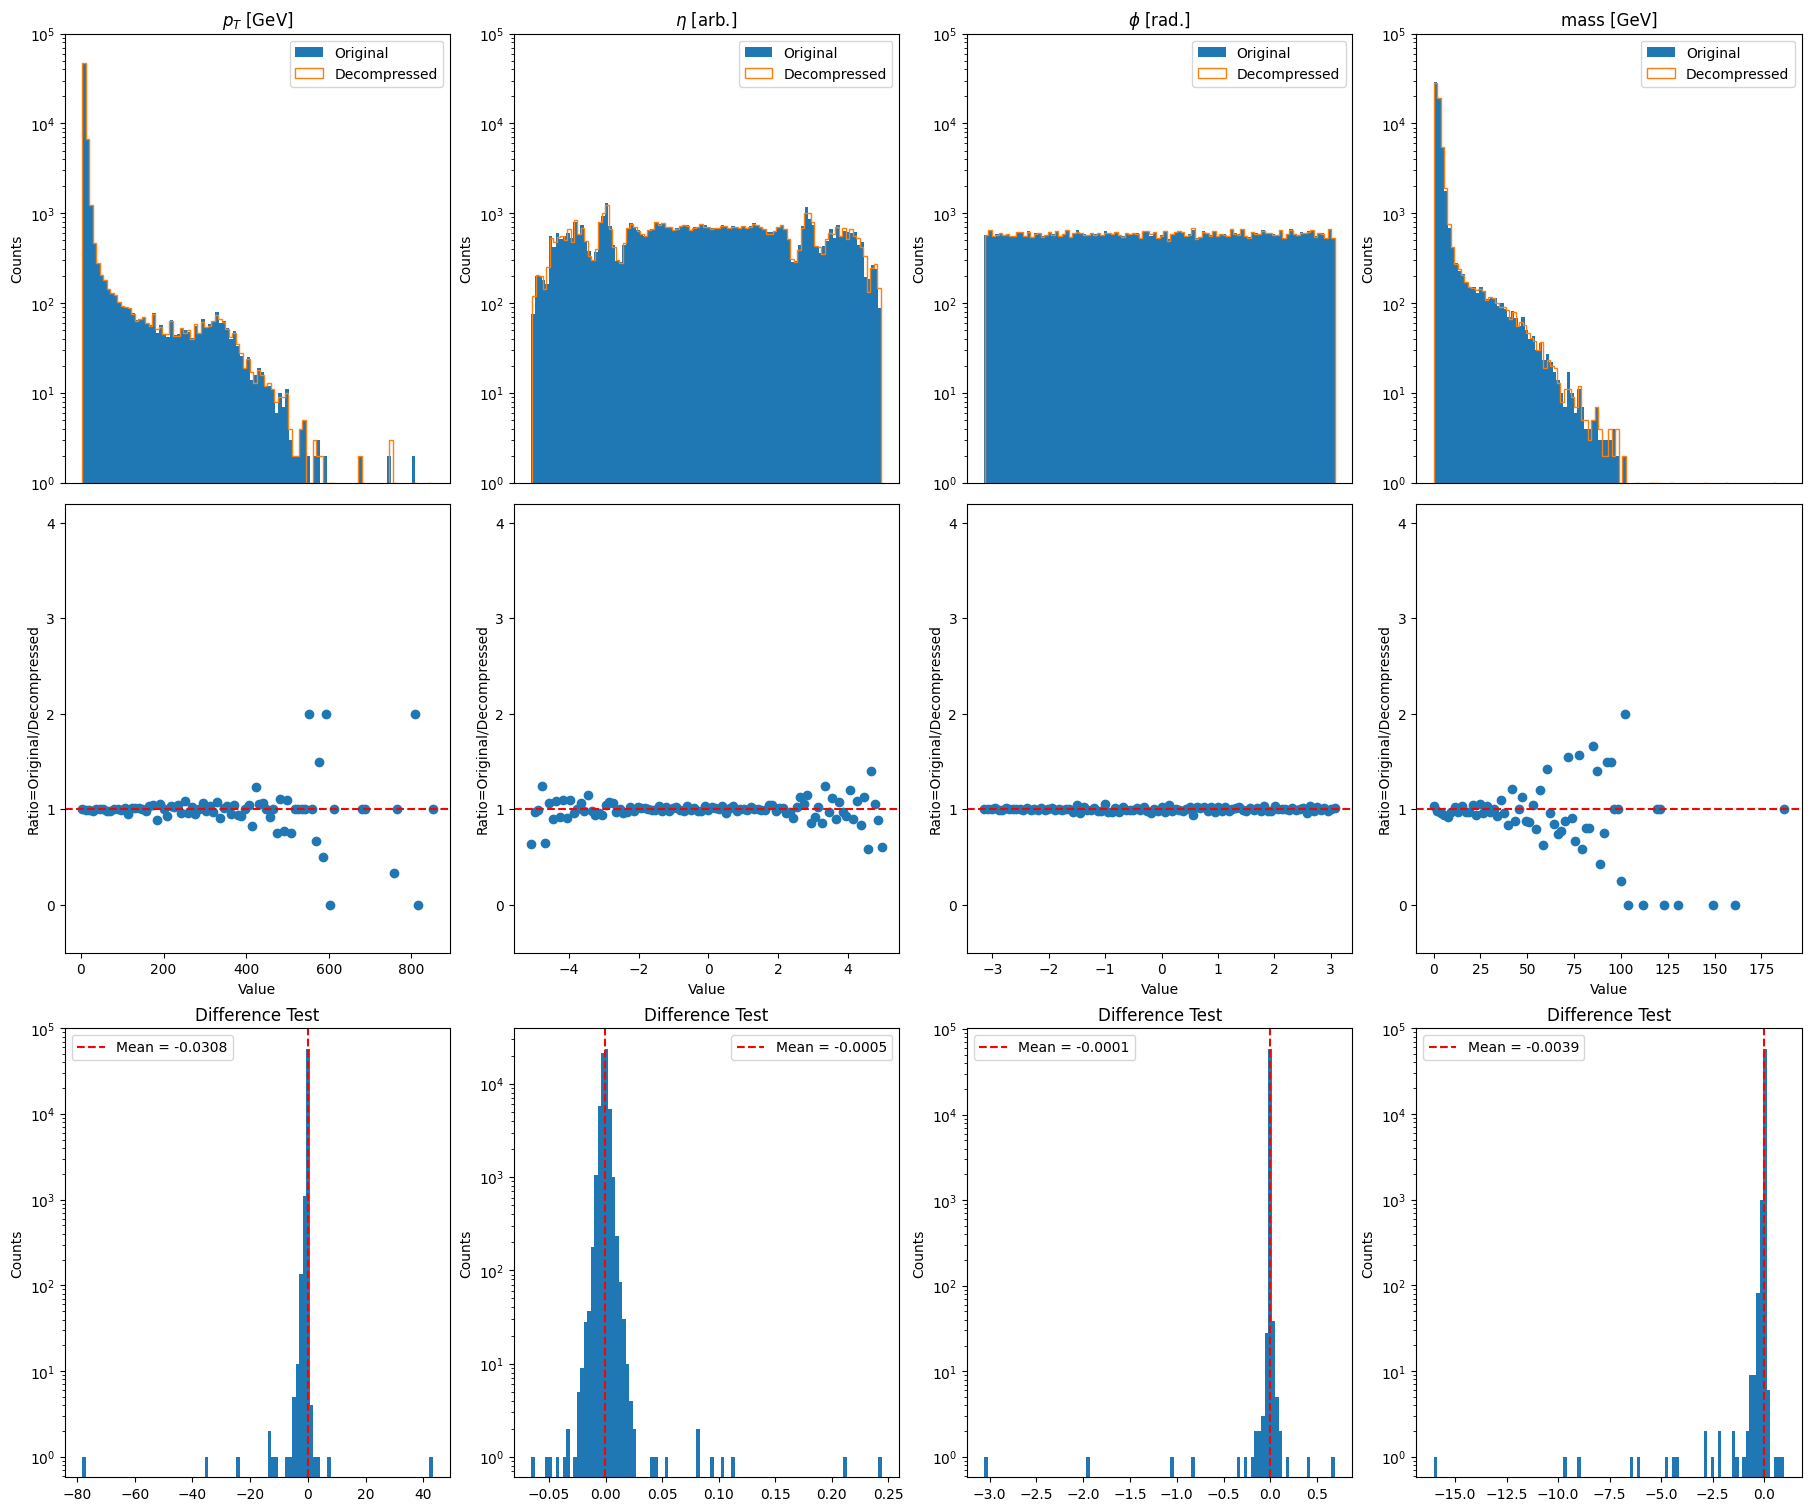

In [ ]:
difference_test = xtest_decompressed-xtest

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
fig.suptitle("Histogram and Ratio Plots for Test")
n_bins = 100
for i in range(4):
    y = []
    y.append(xtest[:, i])
    y.append(xtest_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1,10e4)
    axs[0, i].get_xaxis().set_ticks([])


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio=Original/Decompressed")
    axs[1, i].set_ylim(-0.5,4.2)


    axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference Test")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference_test.pdf', dpi=190)